In [1]:
import pandas as pd
import numpy as np

customer = pd.read_csv("customer_hm.csv")
transactions = pd.read_csv("transactions_hm.csv")
articles = pd.read_csv("articles_hm.csv")

In [ ]:
articles.info()

<class 'pandas.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   article_id                    105542 non-null  int64
 1   product_code                  105542 non-null  int64
 2   prod_name                     105542 non-null  str  
 3   product_type_no               105542 non-null  int64
 4   product_type_name             105542 non-null  str  
 5   product_group_name            105542 non-null  str  
 6   graphical_appearance_no       105542 non-null  int64
 7   graphical_appearance_name     105542 non-null  str  
 8   colour_group_code             105542 non-null  int64
 9   colour_group_name             105542 non-null  str  
 10  perceived_colour_value_id     105542 non-null  int64
 11  perceived_colour_value_name   105542 non-null  str  
 12  perceived_colour_master_id    105542 non-null  int64
 13  perceived_colour_master_n

* 기존 
    * detail_desc 결측치 처리 
    * 상품 
* 추가 
    * 데이터 타입 변환(article_id)
    * 메모리 차지하는 불필요 컬럼 제거(colour_group_name가 있으니 colour_group_code 불필요. 코드 번호가 이름의 정보를 100% 포함하고 있기 때문에 불필요. 다만 선택사항이긴함)
        * 불필요 컬럼 제거하면 혹시 다른 테이블에 영향이 갈까? (데이터 정합성)
        * → '코드성' 컬럼들을 삭제해도 다른 테이블과의 연결(Join)에는 전혀 지장이 없다는 확인 받음
    * 데이터 타입 변환: article_id를 10자리 문자열로 (앞자리 0 보존)
    * 파생변수 : (임시. 팀원과 공유하고 수정할 부분은 수정할 것)
        * Beach & Swim : Swimwear 전체 
            * 20대의 구매가 높을 것으로 예상되기도 함
        * Outdoor & Outer : Coat, Jacket, Outdoor
            * 고연령의 구매가 높을 것으로 예상되기도 함
        * Daily Basics : Jersey Basic, Underwear, T-shirt
            * 전 연령대가 구매하지만 채널 선호도가 갈릴 수 있는 품목
        * Accessories & Shoes : Accessories, Shoes, Bags
            * 온라인에서 구매하기 쉬운 품목이지 않을까

-> 음 데이터 확인하면서 고연령, 저연령대가 정말로 구매 비중이 높은지 먼저 확인하는 게 필요하지 않을까? 매핑할 때 중요한 요소 같은데 이 과정에서 확인하고 넘어가는 게 맞지 않나 싶은데
-> 탐색적 데이터 분석(EDA) 단계를 거치면서 우리가 설정한 가설을 먼저 세워야 할 수도. 팀원들끼리 상의해야 할듯 지금은 임시 매핑 & 가설 수립해서 진행하고, 회의에서 EDA 순서 맞추는 게 필요. 최종 매핑은 회의 이후!

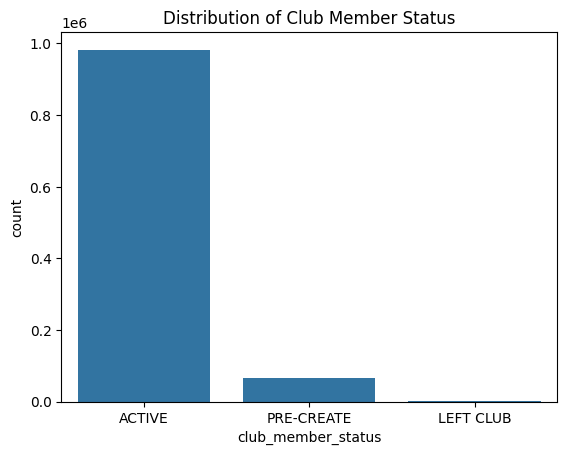

In [3]:
### 추가 EDA 시각화
# club_member_status 시각화로 확인하려면 아래처럼
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=customer, x='club_member_status')
plt.title("Distribution of Club Member Status")
plt.show()

### 2프로의 EDA 수행 단계
* 목표
    * 데이터가 어떻게 생겼는지 파악
    * 값이 이상한 부분(결측치, 이상치) 발견
    * 변수 간 관계에 대한 가설 생성
    * 이후 분석/모델링 방향 결정

1. 기초 통계 및 결측치 확인
    * 각 테이블의 행/열 개수(shape), 데이터 타입, 결측치(isnull), 기초 통계량(describe) 확인
2. 단일 변수 탐색 (Univariate Analysis)
    * 나이 분포(히스토그램), 상품 카테고리 비중(막대그래프), 회원 상태 비율 확인
    * "우리 고객은 주로 몇 살인지, 어떤 상품이 제일 많은지" 등 확인
3. 두 변수 간의 관계 탐색 (Bivariate Analysis) (중요!!!)
    * 연령대별 선호 상품군, 요일별 구매 건수, 채널별 매출액 비교.
    * "진짜로 20대가 수영복을 많이 샀을까?"처럼 두 정보 사이의 상관관계를 확인
4. 이상치 및 특이 패턴 심화 탐색
    * 나이가 100세인 고객의 구매 기록만 따로 보거나, 특정 날짜에 매출이 폭발한 이유 확인.
5. 인사이트 요약 및 전처리 방향 확정 (최종 결론 내리기)
    * 확인 결과 50대는 아우터보다 니트를 선호하니, 매핑 시 니트를 아우터 그룹에 포함하자 등의 결정
    * EDA 결과를 바탕으로 실제 분석에 쓸 **최종 파생변수와 매핑 로직**을 설계

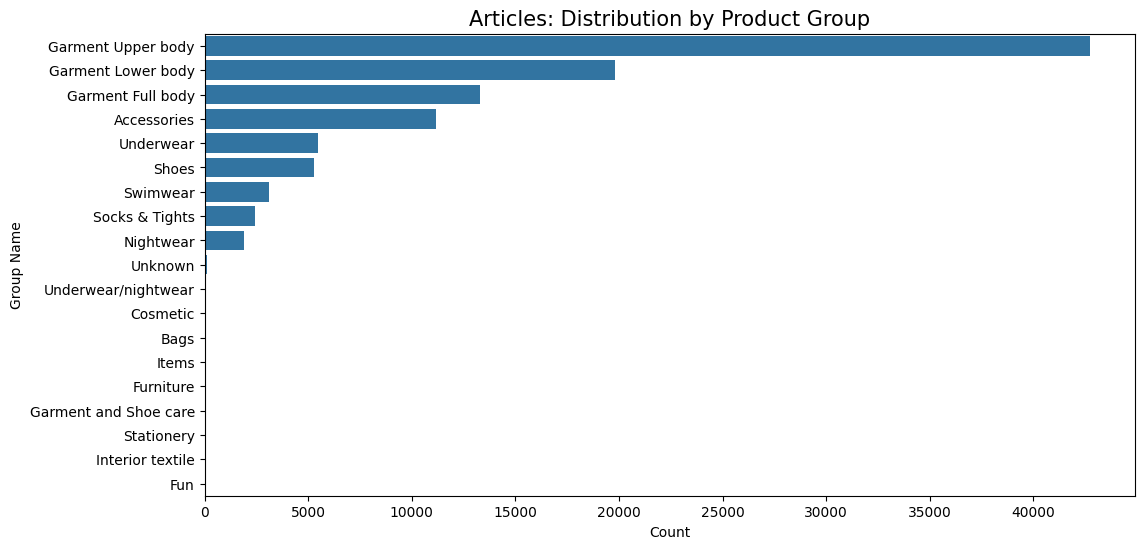

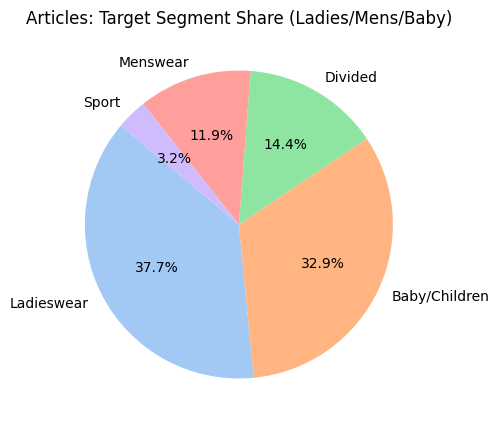

In [4]:

###EDA용 시각화 (w. ai튜터...)
import matplotlib.pyplot as plt
import seaborn as sns


# 1. 상품 그룹(product_group_name)별 분포 확인
plt.figure(figsize=(12, 6))
sns.countplot(data=articles, y='product_group_name', order=articles['product_group_name'].value_counts().index)
plt.title('Articles: Distribution by Product Group', fontsize=15)   #상품 그룹별 데이터 분포
plt.xlabel('Count') #상품 수
plt.ylabel('Group Name')    #그룹명
plt.show()

# 2. 가설 검증용: index_group_name(타겟층) 분포 확인
plt.figure(figsize=(10, 5))
articles['index_group_name'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Articles: Target Segment Share (Ladies/Mens/Baby)')
plt.ylabel('')
plt.show()

### EDA 시각화 후 해석 (첫번째 시각화)
* 1. Articles: Distribution by Product Group (상품 그룹별 데이터 분포)
    * Y축 (Group Name)
        * Garment Upper body (상의류): 약 42,000개 이상으로 압도적 1위
        * Garment Lower body (하의류): 약 20,000개 수준
        * Garment Full body (전신 의류): 약 13,000개 수준
        * Accessories (액세서리): 약 11,000개 수준
        * Underwear (속옷): 약 5,000개 수준
        * Shoes (신발): 약 5,000개 미만
        * Swimwear (수영복): 약 3,000개 수준
    * X축 (Count): 상품의 총 개수 (0 ~ 40,000+)
* 2. Articles: Target Segment Share (타겟 고객층 비중)
        * Ladieswear (여성복): 37.7% (가장 큰 비중)
        * Baby/Children (유아/아동): 33.0%
        * Divided (MZ 타겟): 14.4%
        * Menswear (남성복): 11.9%
        * Sport (스포츠): 3.0%

1. Garment Upper/Lower/Full body의 압도적으로 비중이 큼
    * 상의가 압도적 1위, 하의, 풀바디(전신) 의류가 다음으로 
2. Swimwear는 중위권이다. 
    * 20대의 구매가 많을 것으로 보이는 품목이 분석 대상으로 적절할만한 중간에 위치함! 통계적으로 유의미한 수치가 나올 수 있겠다는 판단 가능
3. 정제의 필요성이 있는 극단치들(매우 낮은 값 존재)
    * Bags, Items, Furniture 등


### EDA 시각화 후 해석 (두번째 시각화)
1. 여성복(Ladieswear)이 가장 큰 비중을 차지함. 20대 여성의 온라인 쇼핑 패턴 분석하기 용이할 것 같다
2. 아동복(Baby/Children) 비중이 두번째로 크다. 
    * 30대의 구매가 높은 걸까? 아니면 선물용? 20대의 쇼핑 목록에는 거의 없겠지만 30대(본인 자녀용), 50대(손주 선물용) 등의 패턴이 나올 수도 있겠다
3. 남성복(Menswear)과 스포츠(Sport)는 상대적으로 낮다. 서브 인사이트 용으로 두는 게 전략적으로 용이할 것이다.
4. divided
    * 이게 뭐..뭐지? 기타 품목인가 싶었는데 H&M의 MZ 타켓팅 라인(크롭, 스트릿 패션 디자인)을 모아둔 것
    * 2026년 기준 현재에도 스웨덴 및 글로벌 시장에서 dicided 라인 확실히 있으나 한국 웹사이트 기준에서는 보이지는 않음. 무신사 used(중고) 디바이디드에이치앤엠 이라는 이름으로 판매되고 있으나 공식 웹사이트에서는 카테고리 따로 X
    * https://divided.brandswebsites.com/?utm_source=chatgpt.com

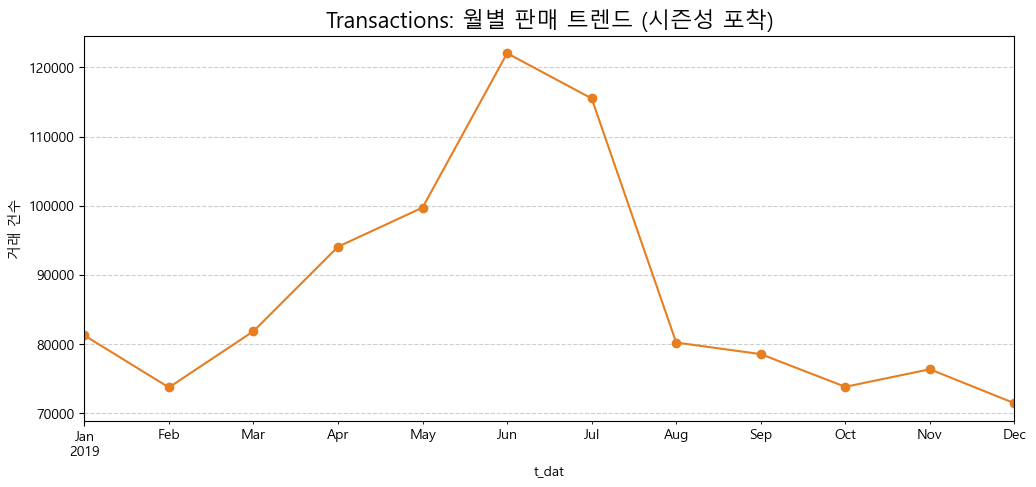

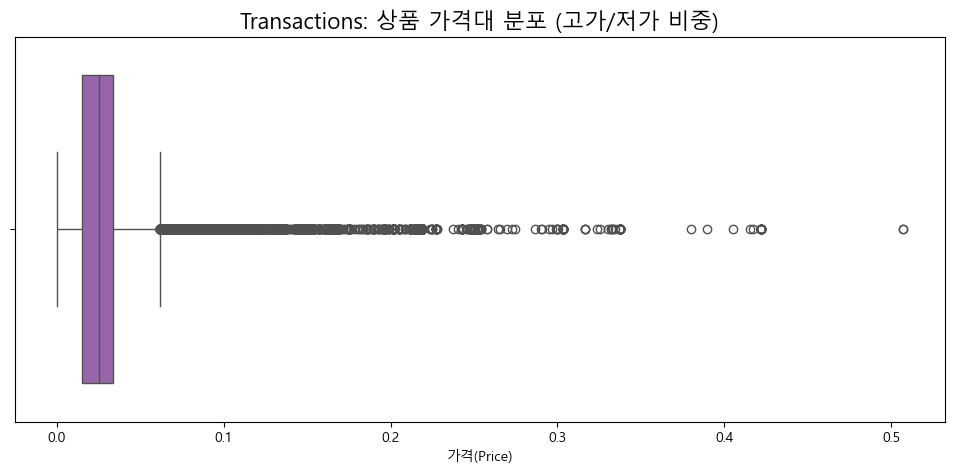

In [ ]:
######## EDA 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 폰트 깨짐 방지를 위한 설정 (Windows 기준 Malgun Gothic)
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

#[transactions]
# 1. 월별 거래량 추이 (시즌성 확인)
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
monthly_sales = transactions.set_index('t_dat').resample('ME').size()

plt.figure(figsize=(12, 5))
monthly_sales.plot(marker='o', color='#e67e22') 
plt.title('Transactions: 월별 판매 트렌드 (시즌성 포착)', fontsize=16)
plt.ylabel('거래 건수')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 2. 가격대 분포 (이상치 및 주력 가격대 확인)
plt.figure(figsize=(12, 5))
sns.boxplot(x=transactions['price'], color='#9b59b6') 
plt.title('Transactions: 상품 가격대 분포 (고가/저가 비중)', fontsize=16)
plt.xlabel('가격(Price)')
plt.show()


### [transaction] 시각화 해석

### [차트 1]



### [차트 2]

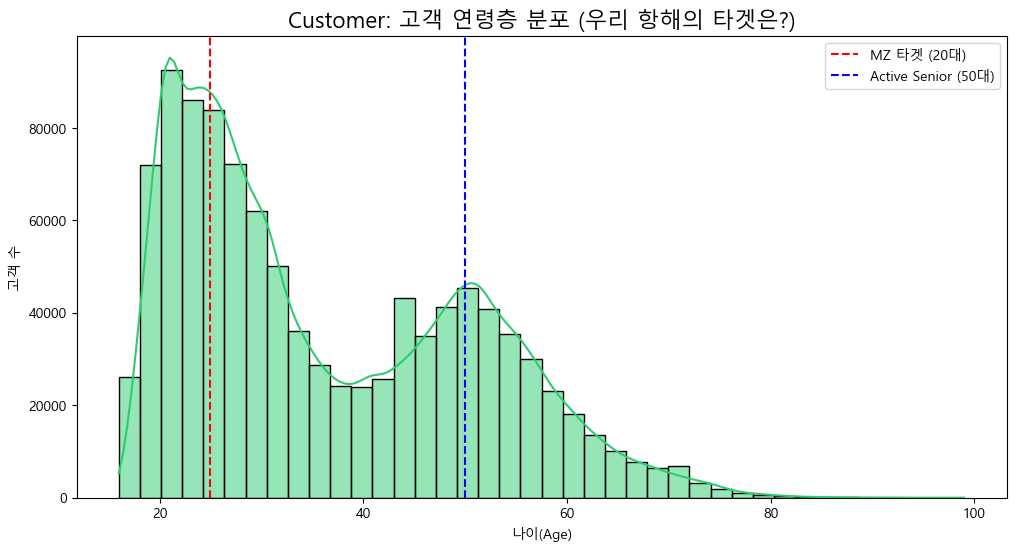

In [6]:
######## EDA 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 폰트 깨짐 방지를 위한 설정 (Windows 기준 Malgun Gothic)
plt.rc('font', family='Malgun Gothic') 
plt.rc('axes', unicode_minus=False)

#[customer]
import matplotlib.pyplot as plt
import seaborn as sns

# 고객 연령대 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(customer['age'], bins=40, kde=True, color='#2ecc71')
plt.axvline(25, color='red', linestyle='--', label='MZ 타겟 (20대)') 
plt.axvline(50, color='blue', linestyle='--', label='Active Senior (50대)')

plt.title('Customer: 고객 연령층 분포 (우리 항해의 타겟은?)', fontsize=16)
plt.xlabel('나이(Age)')
plt.ylabel('고객 수')
plt.legend()
plt.show()

### [customer] 시각화 해석
* 



##데이터 분석 진행도
1. 데이터 로드 -완료
2. EDA (탐색·확인·가설 세우기) -완료
3. 전처리 (EDA에서 발견한 문제를 실제로 수정)
4. 전처리 결과 재확인용 EDA
5. 분석 / 모델링

2, 3 끝내면 될듯 오늘

In [7]:
###전처리
# 1. ID 형식 통일 (다른 테이블과 과정 동일해야함. 회의 때 의견 통일)
# article_id를 10자리 문자열로 변환하여 앞의 '0'이 잘리지 않게
articles['article_id'] = articles['article_id'].astype(str).str.zfill(10)

# 2. 결측치(NULL) 제어 (detail_desc의 NULL값을 No Description로)
articles['detail_desc'] = articles['detail_desc'].fillna('No Description')

# 3. 불필요 컬럼 제거 (메모리 줄이기)
# Name(이름)이 존재하여 중복 정보인 Code(코드성 숫자) 컬럼 불필요함. 제거!
cols_to_drop = [
    'product_type_no', 
    'graphical_appearance_no', 
    'colour_group_code', 
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_code',
    'index_group_no',
    'section_no',
    'garment_group_no'
]
articles_cleaned = articles.drop(columns=cols_to_drop) 

# 4. 결과 확인!!! 

In [8]:
# 4-1. [ BEFORE & AFTER 확인]

# 확인 1: ID가 문자열로 잘 바뀌었나요?
print(f"변경 전 ID 타입: {articles['article_id'].dtype}")
print(f"변경 후 ID 타입: {articles_cleaned['article_id'].dtype} (0이 포함된 10자리 확인: {articles_cleaned['article_id'].iloc[0]})")

# 확인 2: 결측치가 잘 채워졌나요?
print(f"결측치 처리 전 비어있는 개수: {articles['detail_desc'].isnull().sum()}개")
print(f"결측치 처리 후 비어있는 개수: {articles_cleaned['detail_desc'].isnull().sum()}개")

# 확인 3: 중복된 짐(컬럼)을 얼마나 덜어냈나요?
print(f"전처리 전 컬럼 개수: {len(articles.columns)}개")
print(f"전처리 후 컬럼 개수: {len(articles_cleaned.columns)}개 (중복 데이터 {len(cols_to_drop)}개 제거 완료!)")

변경 전 ID 타입: str
변경 후 ID 타입: str (0이 포함된 10자리 확인: 0108775015)
결측치 처리 전 비어있는 개수: 0개
결측치 처리 후 비어있는 개수: 0개
전처리 전 컬럼 개수: 25개
전처리 후 컬럼 개수: 15개 (중복 데이터 10개 제거 완료!)


In [9]:
# 4-2. 그냥 보려면
articles.dtypes
articles_cleaned.dtypes
# articles.isnull().sum() #처리 전 NULL값
# articles_cleaned.isnull().sum() #처리 후
# len(articles.columns)   #25
# len(articles_cleaned.columns)   #15
# len(cols_to_drop)   #제거된 컬럼 (10개)

article_id                        str
product_code                    int64
prod_name                         str
product_type_name                 str
product_group_name                str
graphical_appearance_name         str
colour_group_name                 str
perceived_colour_value_name       str
perceived_colour_master_name      str
department_name                   str
index_name                        str
index_group_name                  str
section_name                      str
garment_group_name                str
detail_desc                       str
dtype: object